# Map picking trends

In [3]:
from s2_analytics.collect.summary_collector import SummaryCollector
import sqlite3

import os

import pandas as pd
import seaborn as sns
from IPython.core.display import Markdown
from pandas import DataFrame

from s2_analytics.collect.sqlite_collector import SqliteCollector
from s2_analytics.filters import PLAYLIST_CTF
from s2_analytics.importer import import_games
from s2_analytics.rolling_average import RollingAveragePeriod


AVG_PERIOD_LONG = RollingAveragePeriod(14, 3, 0.75)
AVG_PERIOD_SHORT = RollingAveragePeriod(7, 3, 0.75)

def dump_csv(df: DataFrame, id: str):
    csv_path = f"data/{id}.csv"
    csv_abs_path = f"{os.getcwd()}/build/markdown/{csv_path}"
    df.to_csv(csv_abs_path)
    display(Markdown(f"Chart data: [csv]({csv_path})"))


conn = sqlite3.connect("file::memory:")
sqlite_collector = SqliteCollector(sqlite_conn=conn).init()
summary_collector = SummaryCollector(conn, sqlite_collector)
import_games("logs_ranked/", period_days=AVG_PERIOD_LONG.days_of_data_needed,
             processors=[sqlite_collector, summary_collector], game_filters=[PLAYLIST_CTF])
con = sqlite_collector.connection
cur = con.cursor()
cur.execute("""
create table map_picks_by_date as
    select distinct comb.date,
                comb.mapName,
                sum(iif(r.game is null, 0, 1)) rounds_played -- count only if not null
                -- all date+map combinations
    from (select *
      from (select distinct dates.date from round dates)
               cross join (select distinct mapName from round maps)) comb
         left outer join round r on r.date = comb.date and r.mapName = comb.mapName
    group by comb.date, comb.mapName
""")

pass

## Data summary

In [4]:
import tabulate

table = summary_collector.get_summary().to_table()
tabulate.tabulate(table, tablefmt='html')

First game,2023-01-27
Last game,2023-03-20
Games total,798
Rounds total,1995
Games in playlist `CTF-Standard-2`,7
Games in playlist `CTF-Standard-4`,11
Games in playlist `CTF-Standard-6`,779
Games in playlist `CTF-Standard-8`,1


In [5]:
query = """
select
    playlistCode,
    count(1) games_count
from game group by playlistCode
"""
pd.read_sql_query(query, con)

,playlistCode,games_count
0,CTF-Standard-2,7
1,CTF-Standard-4,11
2,CTF-Standard-6,779
3,CTF-Standard-8,1


## Map picking trends

Chart data: [csv](data/map-trends-a-g-14-days-avg.csv)

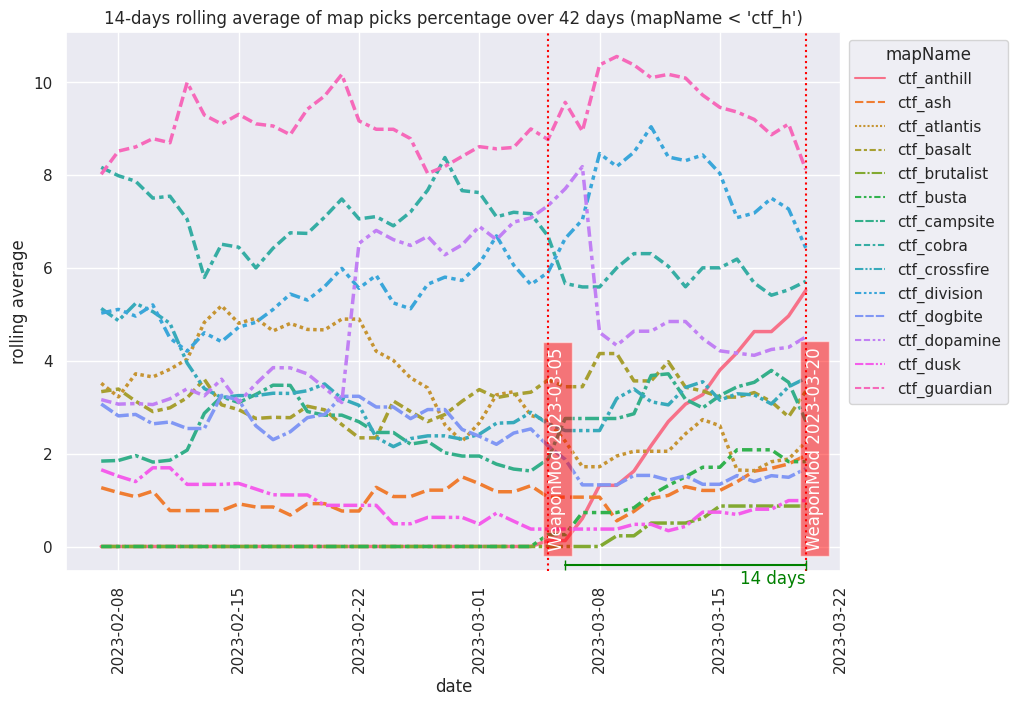

In [6]:

from datetime import timedelta
from matplotlib.lines import Line2D
from s2_analytics.constants import WEAPON_MODS_DATES, WEAPON_MODS
from matplotlib.ticker import FixedLocator


def rolling_average_map_pick(condition, id, period: RollingAveragePeriod, height=10):
    df = pd.read_sql_query(f"""
    select
        mapName,
        date,
        100.0 * rounds_played / (select sum(rounds_played) from map_picks_by_date mpd2 where mpd.date = mpd2.date) as pick_percentage
    from map_picks_by_date mpd
        where {condition}
        and date >= datetime('now', '-{period.days_of_data_needed} days')
    """, con, parse_dates=['date'])
    def generate_rolling_average_plot(df, period:RollingAveragePeriod):
        groupby = df.groupby("mapName", as_index=False, group_keys=False)

        df[f"rolling average"] = groupby.apply(
            lambda grp, freq: grp.rolling(freq, on='date', min_periods=period.min_days_for_avg)['pick_percentage'].mean(),
            f"{period.window_days}D")

        sns.set(rc={'figure.figsize': (10, height)})
        plt = sns.lineplot(df, x="date", y=f"rolling average", style="mapName",
                           hue="mapName", linewidth=2.5)
        plt.xaxis.set_major_locator(FixedLocator(plt.get_xticks().tolist()))
        plt.set_xticklabels(plt.get_xticklabels(), rotation=90)
        plt.set_title(
            f"{period.window_days}-days rolling average of map picks percentage over {period.total_days_visible} days ({condition})")
        sns.move_legend(plt, "upper left", bbox_to_anchor=(1, 1))

        # weaponmod marker
        chart_start_date = df[df.apply(lambda x: not pd.isnull(x["rolling average"]), axis=1)]["date"].min()
        for wm in WEAPON_MODS:
            if wm.datetime > chart_start_date:
                plt.axvline(wm.datetime, color="red", linestyle="dotted", zorder=3)
                plt.text(wm.datetime, 0, wm, rotation=90, color="white",
                         bbox=dict(facecolor='red', alpha=0.5), zorder=3)

        # average period marker
        max_date = df["date"].max()
        plt.add_line(
            Line2D([max_date - timedelta(days=period.window_days), max_date], [-0.4, -0.4], color="green", zorder=3,
                   marker="|", markersize=7))
        plt.text(max_date, -0.5, f"{period.window_days} days", color="green", ha="right", va="top", zorder=3)

        return plt, df

    dump_csv(df, f"map-trends-{id}-{period.window_days}-days-avg")
    generate_rolling_average_plot(df, period)


rolling_average_map_pick("mapName < 'ctf_h'", "a-g", AVG_PERIOD_LONG, height=7)
pass

Chart data: [csv](data/map-trends-h-z-14-days-avg.csv)

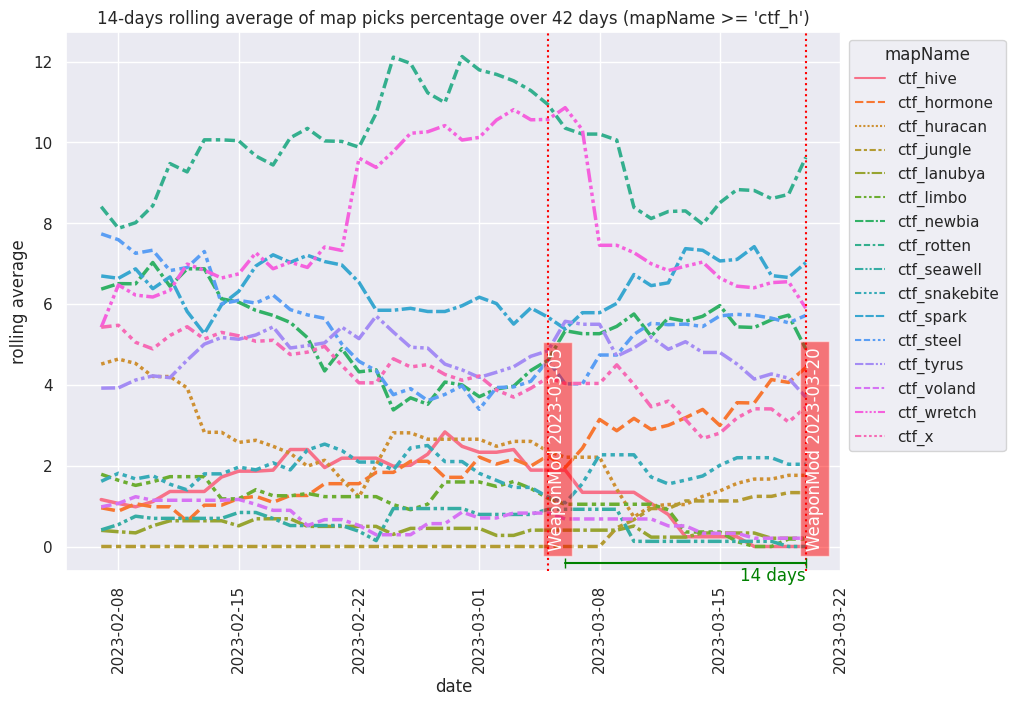

In [7]:
rolling_average_map_pick("mapName >= 'ctf_h'", "h-z", AVG_PERIOD_LONG, height=7)
pass

# yeah apparently someone managed to play ctf on dm_arena in game 1672178428906

## Maps not played in last 7 days

In [8]:
pd.read_sql_query(f"""
    select * from
        (select
            mapName,
            max(date) last_played
        from round
        group by mapName)
    where last_played < datetime('now', '-7 day')
    order by last_played desc
    """, con)

,mapName,last_played
0,ctf_lanubya,2023-03-14
1,ctf_voland,2023-03-14
2,ctf_seawell,2023-03-05
3,ctf_hive,2023-03-03
